In [13]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
train_dataset_path = r'D:\dungnd\data\Folder_1\train'
validation_dataset_path = r'D:\dungnd\data\Folder_1\val'

In [3]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
BATCH_SIZE = 32

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 1442 images belonging to 2 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 412 images belonging to 2 classes.


In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : anhgoc
1 : catghep


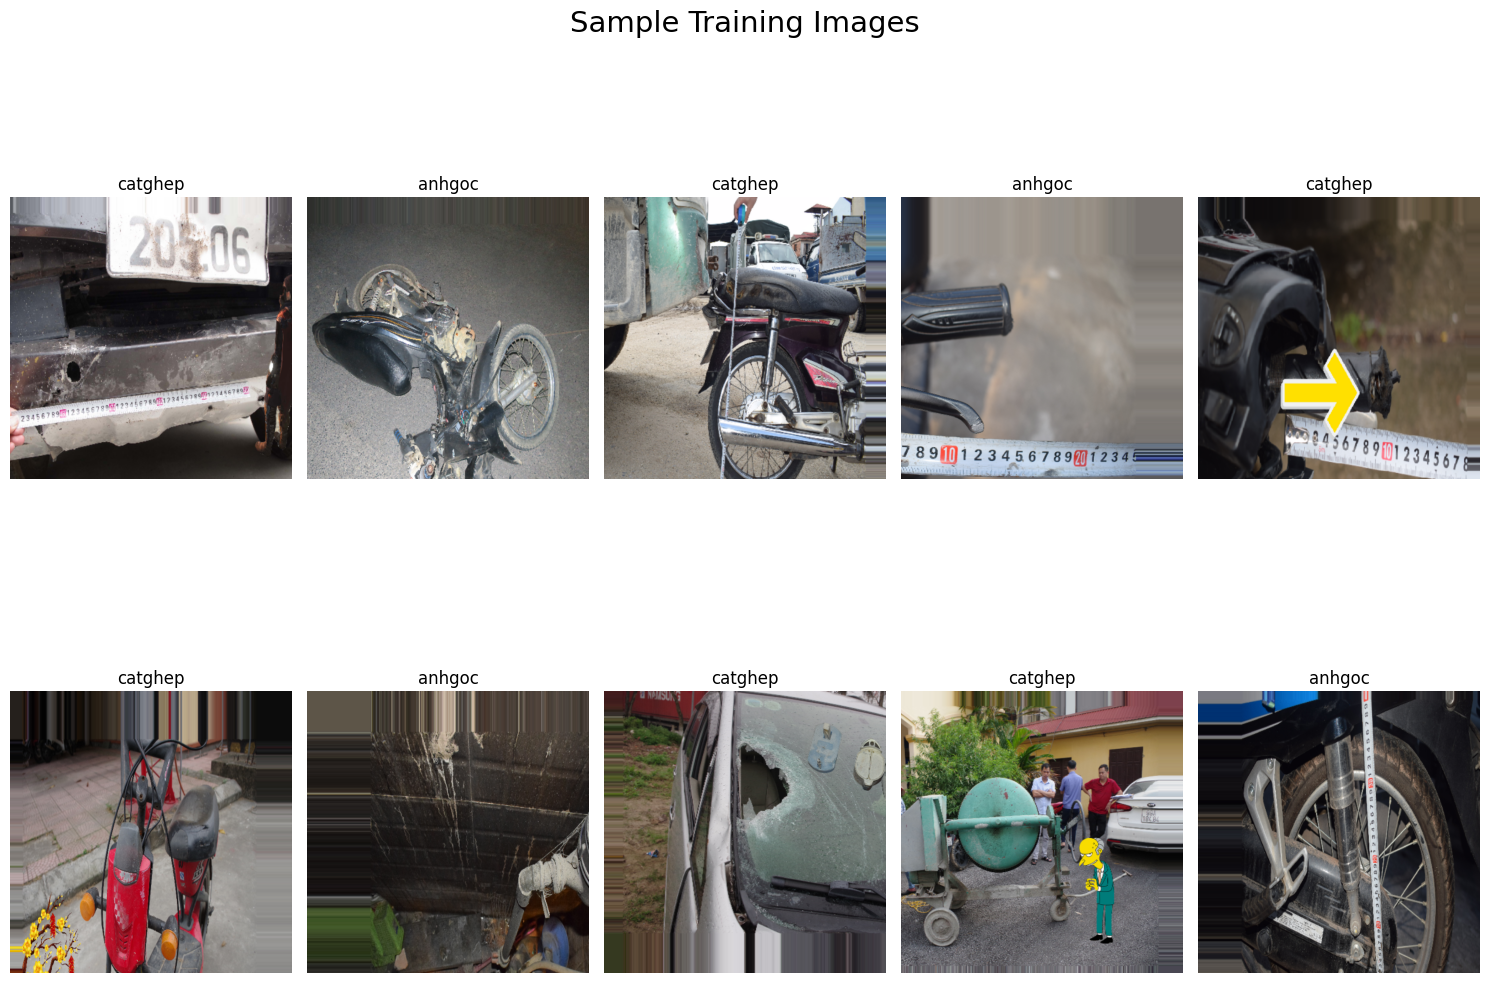

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [10]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
    ])
    
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 508, 508, 128)     9728      
                                                                 
 activation_3 (Activation)   (None, 508, 508, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 254, 254, 128)     0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 254, 254, 128)     512       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 252, 252, 64)      73792     
                                                                 
 activation_4 (Activation)   (None, 252, 252, 64)     

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=['accuracy'])
checkpoint_filepath = 'D:\\dungnd\\GraduationProject\\checkpoint\\Folder_1\\model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

history = model.fit(train_generator, epochs=40, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr, checkpoint_cb])

Epoch 1/40
46/46 - 1375s - loss: 15.8199 - accuracy: 0.5104 - val_loss: 10.9005 - val_accuracy: 0.4587 - lr: 0.0010 - 1375s/epoch - 30s/step
Epoch 2/40
46/46 - 1415s - loss: 11.2206 - accuracy: 0.5319 - val_loss: 13.3520 - val_accuracy: 0.4660 - lr: 0.0010 - 1415s/epoch - 31s/step
Epoch 3/40
46/46 - 1390s - loss: 5.5743 - accuracy: 0.5187 - val_loss: 1.4619 - val_accuracy: 0.5291 - lr: 0.0010 - 1390s/epoch - 30s/step
Epoch 4/40
46/46 - 1423s - loss: 3.9902 - accuracy: 0.5506 - val_loss: 5.7012 - val_accuracy: 0.4660 - lr: 0.0010 - 1423s/epoch - 31s/step
Epoch 5/40
46/46 - 1504s - loss: 1.8761 - accuracy: 0.5430 - val_loss: 1.1469 - val_accuracy: 0.4854 - lr: 0.0010 - 1504s/epoch - 33s/step
Epoch 6/40
46/46 - 1459s - loss: 1.2131 - accuracy: 0.5499 - val_loss: 1.7573 - val_accuracy: 0.5631 - lr: 0.0010 - 1459s/epoch - 32s/step
Epoch 7/40
46/46 - 1482s - loss: 0.8817 - accuracy: 0.5458 - val_loss: 0.9671 - val_accuracy: 0.4684 - lr: 0.0010 - 1482s/epoch - 32s/step
Epoch 8/40
46/46 - 1439

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

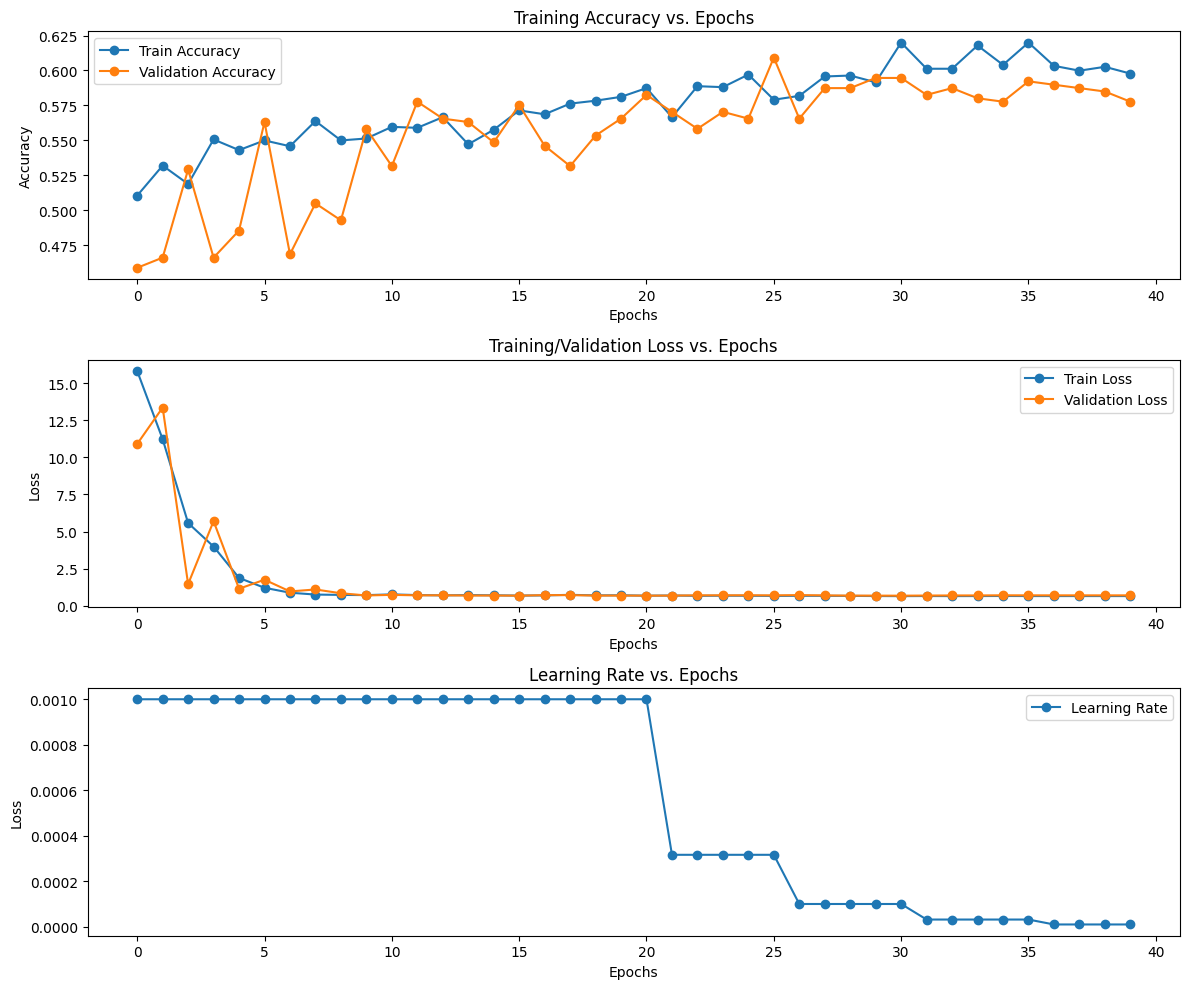

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [44]:
model.save(r'D:\dungnd\GraduationProject\checkpoint\Folder_1\anhgoc_catghet.h5')

In [18]:
from sklearn.metrics import classification_report

# Predict on validation data
predictions = model.predict(validation_generator)

# Get the class with the highest probability as the predicted class
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

13/13 [==============================] - 107s 8s/step
              precision    recall  f1-score   support

      anhgoc       0.43      0.20      0.27       192
     catghep       0.52      0.77      0.63       220

    accuracy                           0.50       412
   macro avg       0.48      0.49      0.45       412
weighted avg       0.48      0.50      0.46       412



In [19]:
test_dataset = r'D:\dungnd\data\Folder_1\test'
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 208 images belonging to 2 classes.


7/7 [==============================] - 56s 8s/step


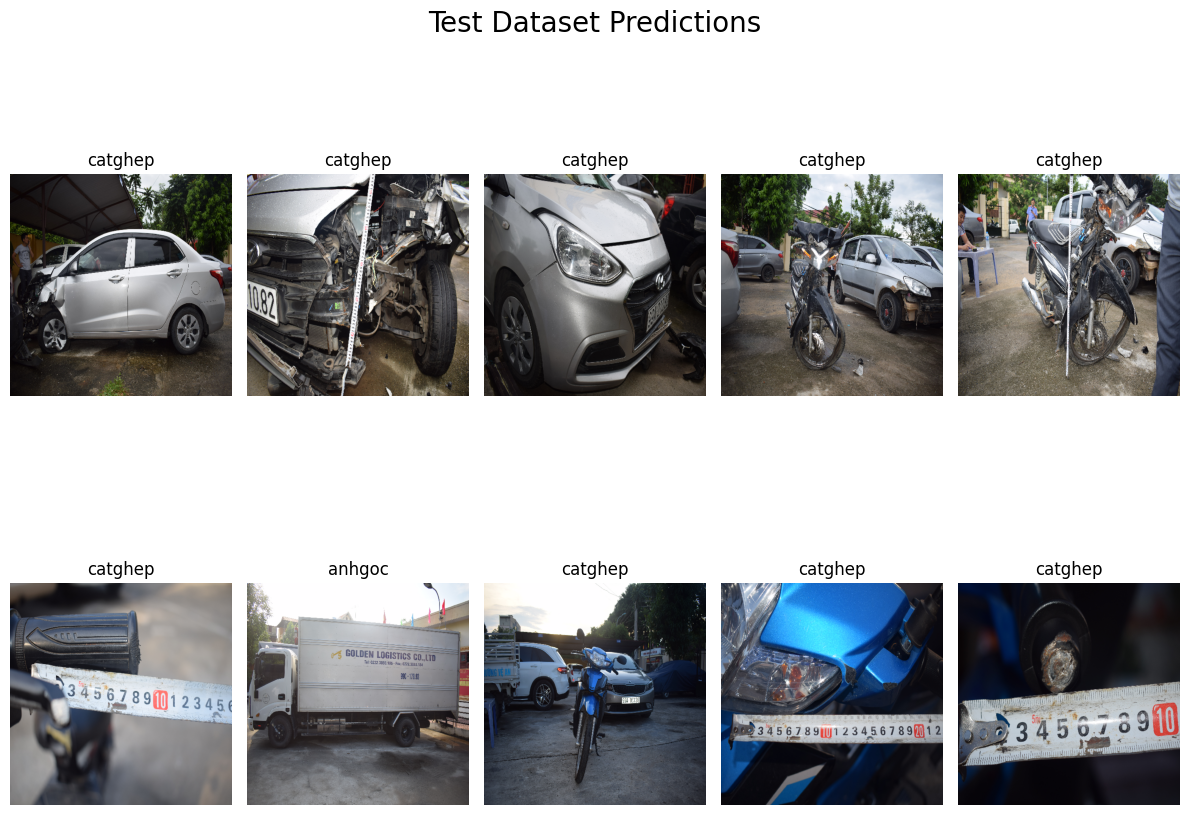

In [20]:
predictions = model.predict(test_generator)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 56s 8s/step - loss: 0.7365 - accuracy: 0.5577
Test Loss:     0.736505389213562
Test Accuracy: 0.557692289352417


In [46]:
import cv2
from tensorflow.keras.models import load_model

my_model=load_model(r'D:\dungnd\GraduationProject\checkpoint\Folder_1\anhgoc_catghet.h5')

test_image_path = r"D:\dungnd\data\Folder_1\test\anhgoc\DSC_0777.JPG"

# Load and preprocess the test image
img = cv2.imread(test_image_path)
img = cv2.resize(img, (512, 512))  # Resize image to match the input size of the model
img = np.expand_dims(img, axis=0)   # Add batch dimension
img = img / 255.0             
prediction = my_model.predict(img)
print(prediction)

class_idx = np.argmax(prediction)
print("Predicted class: Class ", labels[class_idx])

1/1 [==============================] - 0s 468ms/step
[[0.41550252 0.5844975 ]]
Predicted class: Class  catghep
